In [2]:
import jax.numpy as jnp
import jax
from jax import grad, hessian, jacobian, vmap, random
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64",True)

Implement Gauss-Newton Iteration for Nonlinear least-squares: 
$$ \mathrm{min}_{z \in \Omega} \hspace{3pt} \| F(z) - y \|^2$$

Where $F$ is a nonlinear function. Assuming differentiability, we take $$F(z) \approx F(x) + F'(x)(z - x)$$ and substitute in objective function: $$\|F(z) - y\|^2 \approx \| F'(x)(z - x) - (y - F(x))\|^2$$ and since the problem is now linear in $z$, we may simply take the gradient and obtain the normal equations for this linearized case: 


$$x_{k + 1} = x_k + (F'(x_k)^\top F'(x_k))^{-1}F'(x_k)^\top(y - F(x_k))$$

and Jax handles Jacobians quite nicely. 


Jax's jacobian expects a black-box function f(x) that takes a JAX array x and returns a JAX array y, possibly of different dimensions. Hence, if we start with a multiargument function like f(x, y), we need to wrap it before using jacobian. However, we may still use f(x, y) if we want to treat one of the inputs as constants, by using the argnums parameter.   

In [3]:
def f(x, y, z):
    return jnp.array([
        x*y*z,
        x**2*z
                       ])

def fun(x):
    return f(x[0], x[1], x[2])

# Where to evaluate Jacobians
x = jnp.array([2., 1., 1.])

fun_jac = jacobian(fun)

print(fun_jac(x))

# Should be  (yz, xz, xy \\ 2xz, 0 , x^2) if computing jacobian wrt to x, y, z

# Say we assume y, z are actually constant, so that f(x, y, z) can be though as g(x): R -> R. Then we could also do 
# In this case we simply differentiate wrt x component by component: Jf = (yz, 2xz)
fun_jacx = jacobian(f, argnums=0)

print(fun_jacx(x[0], x[1], x[2]))

[[1. 2. 2.]
 [4. 0. 4.]]
[1. 4.]


Having clarified all of this, we may proceed by considering the nonlinear least squares function $ F(z)_i = z[i]^i $ and the solution vector $y[i] = i$ (im so unoriginal lol). This can be easily decoupled, so jacobian is diagonal, etc. 

In [4]:
def F(x):
    return jnp.pow(x, jnp.arange(1, len(x)+1))


# Also consider more complicated function:

def g(x, y, z):
    return jnp.array([
        10*jnp.sin(x*y)**2*jnp.cos(z*2), 
        8*jnp.tanh(x - z + 2*y)/(1 + x**2)
    ])

def G(x):
    return g(x[0], x[1], x[2])

F_jac = jacobian(F)

x0 = jnp.array([5., 4., 2.])

y = jnp.array([1, 2])

# Implementing using the Levenberg–Marquardt algorithm, i.e. Gauss-Newton but with a trust region approach. 
# Higher regularization means more stable, but may take longer to converge 

def LM(fun,y, max_iters, x0, tol = 1e-8, reg = 1e-10, verbose = False):
    errs = []
    x = x0
    obj_val = jnp.linalg.norm(fun(x) - y)

    errs.append(obj_val)
    for iter in range(max_iters):
        
        Jac = jacobian(fun)(x)

        x = x + jnp.linalg.solve(Jac.T @ Jac + reg*jnp.eye(len(x)), Jac.T @ (y - fun(x)))

        obj_val = jnp.linalg.norm(fun(x) - y)
        errs.append(obj_val)
        if verbose: print(iter, obj_val)
        if jnp.linalg.norm(fun(x) - y) < tol:
            return x, errs

    return x, errs

In [13]:
x, errs = LM(G, y, 200, x0, reg=1e-4, verbose=True, tol=1e-14)

0 2.138263166174813
1 2.81382966514309
2 7.054661211988842
3 7.70495425773606
4 6.670984367802405
5 6.909422863607649
6 5.577988965590038
7 4.621539751175753
8 2.10318483604333
9 2.4921100804806127
10 2.127595337675866
11 9.197576891053192
12 8.692432418630812
13 5.936358808190401
14 7.75171825564723
15 4.796215487889961
16 4.067953474450354
17 2.0069290473151944
18 2.604225069885318
19 3.535762856043449
20 5.191798383541884
21 5.067933619736439
22 9.14878265575898
23 8.382265839201366
24 5.339494620064843
25 8.413140831814037
26 2.224248376121582
27 2.168301518785661
28 4.598588299597969
29 8.490442000019684
30 1.9902813300521431
31 9.087043140448753
32 8.91747262852353
33 2.1894847431197073
34 7.581990183937275
35 8.3513901703761
36 7.7620499710321385
37 8.86921224485715
38 5.278304195910933
39 5.174648512260439
40 8.439203715930521
41 4.062871457862103
42 6.685291573238409
43 8.983778214657152
44 2.1458069087843517
45 8.288447633508001
46 9.184924833295076
47 8.623061061970894
48 8.

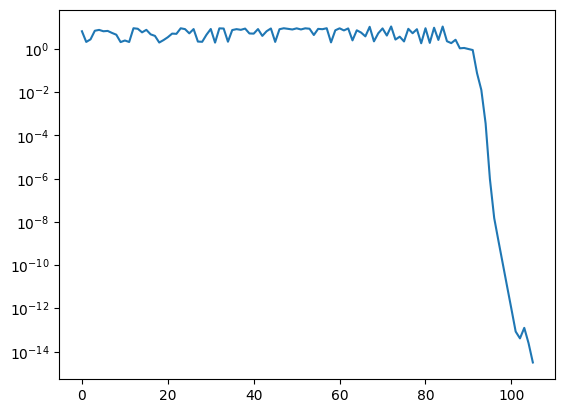

In [14]:
plt.plot(errs)
plt.yscale('log')

## RELAXED GAUSS-NEWTON

Now if the minimization problem is given by $$ \min_{z} \quad z^\top K^{-1} z + \frac{1}{\beta^2} \|F(z) - y\|^2$$ after linearizing $F$ we obtain a similar formula for $z$ (actually, also including trust region term coming from an extra penalization of the type $\lambda \|z - z_k\|^2$):
$$ z = (\frac{1}{\beta^2}J_F^\top J_F + K_{\phi, \phi}^{-1} + \lambda I)^{-1}\frac{1}{\beta^2}J_F^\top (y - F(z_k))$$
where $J_F$ is the Jacobian of $F$.

In [ ]:
def relaxed_LM(K, F ,y, beta, max_iters, x0, tol = 1e-8, reg = 1e-10, verbose = False):
    errs = []
    x = x0
    obj_val = jnp.linalg.norm(F(x) - y)

    errs.append(obj_val)
    for iter in range(max_iters):
        
        Jac = jacobian(F)(x)

        C = Jac.T @ Jac/beta**2+ reg*jnp.eye(len(x))
        x = 1/beta**2 * K @ (Jac.T @ (y - F(x)) - jnp.linalg.solve(jnp.eye(len(x)) + C @ K, K @ Jac.T @ (y - F(x))))

        obj_val = jnp.linalg.norm(F(x) - y)
        errs.append(obj_val)
        if verbose: print(iter, obj_val)
        if obj_val < tol:
            return x, errs

    return x, errs

: 